# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

In [2]:
batch_size = 32
epochs = 20
num_neurons = 64
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("./data_simplified/collected_sLI_tLO.csv", delimiter='\t')

all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLI_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tLO.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)

# filter out count redexes for 0 - 19 & too long tokens sequences
print(f"Count samples before filtering: {len(all_data)}")
all_data = all_data[[redexes < 20 for redexes in all_data["redexes"]]].reset_index(drop=True)
print(f"Count samples after filtering redexes: {len(all_data)}")
all_data = all_data[[len(tokenize_data(simplified_term)) <= 1_000 for simplified_term in all_data['simplified_term']]]
print(f"Count samples after filtering tokens sequences: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simplified_term"].tolist(), all_data["redexes"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count samples before filtering: 9566
Count samples after filtering redexes: 8911
Count samples after filtering tokens sequences: 8908

Count training samples: 7126
Count testing samples: 1782


In [26]:
len(all_data["simplified_term"].unique())

7319

In [5]:
# one-hot encode y-data
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [6]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [7]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 1782
len(train_data) = 7126


In [8]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def test_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [9]:
model = Sequential()
model.add(LSTM(units=num_neurons,
               input_shape=(None, onehot_dims)))
model.add(Dense(20, activation='sigmoid'))

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 18964 (74.08 KB)
Trainable params: 18964 (74.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(train_generator(), steps_per_epoch=7126, epochs=epochs, verbose=1)

Epoch 1/20
7126/7126 [==============================] - 127s 18ms/step - loss: 0.1440 - accuracy: 0.2553
Epoch 2/20
7126/7126 [==============================] - 111s 16ms/step - loss: 0.1361 - accuracy: 0.2798
Epoch 3/20
7126/7126 [==============================] - 115s 16ms/step - loss: 0.1321 - accuracy: 0.3021
Epoch 4/20
7126/7126 [==============================] - 110s 15ms/step - loss: 0.1061 - accuracy: 0.4607
Epoch 5/20
7126/7126 [==============================] - 111s 16ms/step - loss: 0.0653 - accuracy: 0.7252
Epoch 6/20
7126/7126 [==============================] - 112s 16ms/step - loss: 0.0418 - accuracy: 0.8221
Epoch 7/20
7126/7126 [==============================] - 123s 17ms/step - loss: 0.0322 - accuracy: 0.8724
Epoch 8/20
7126/7126 [==============================] - 121s 17ms/step - loss: 0.0392 - accuracy: 0.8622
Epoch 9/20
7126/7126 [==============================] - 121s 17ms/step - loss: 0.0239 - accuracy: 0.9030
Epoch 10/20
7126/7126 [==============================] 

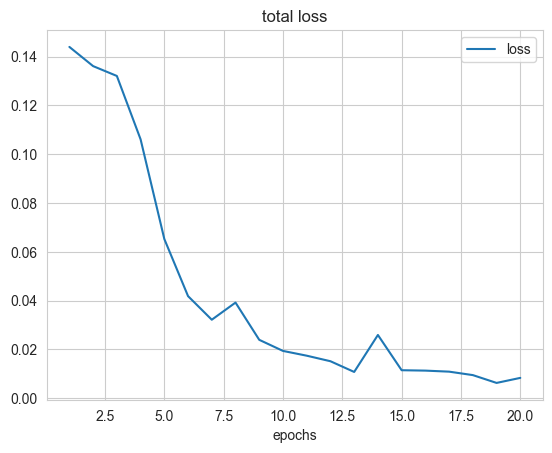

In [14]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

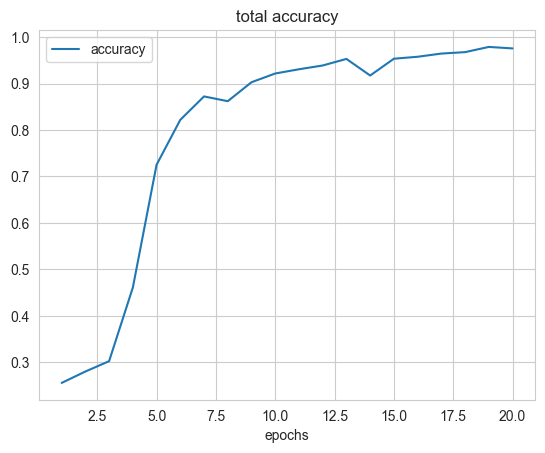

In [15]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [21]:
y_test_pred = []
for x_ in x_test:
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

In [22]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

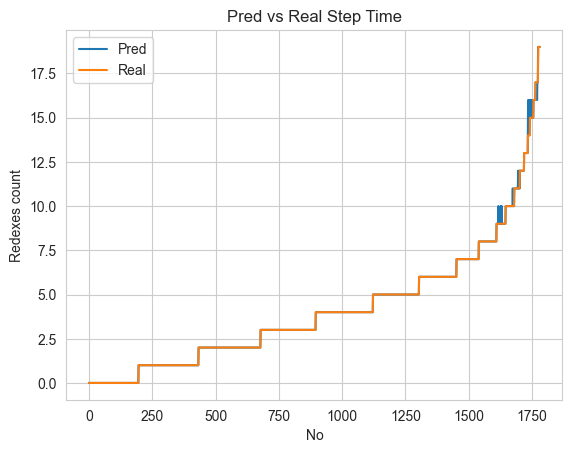

In [24]:
y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [25]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.9904601571268238


In [27]:
model_structure = model.to_json()
with open("./fine_models/v3_lstm_no_seq_class.json", 'w') as json_file:
    json_file.write(model_structure)

model.save_weights("./fine_models/v3_lstm_no_seq_class.h5")